# Galaxy vs quasars

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from astroML.utils import completeness_contamination


#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new it's computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


In [5]:
data = pd.read_csv("../solutions/galaxyquasar.csv")
#plt.hist(data, int(len(data)**0.5))

le = LabelEncoder()
data["class"] = le.fit_transform(data['class'])

class_names= le.classes_

labels = le.inverse_transform(data['class'])

In [6]:
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,1,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,0,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,0,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,0,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,1,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,0,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,0,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,0,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,0,0.112571,0.000009


In [9]:
u = data['u']
g = data['g']
r = data['r']
i = data['i']
z = data['z']

class_ = data['class']

## exploring the data with a corner plot

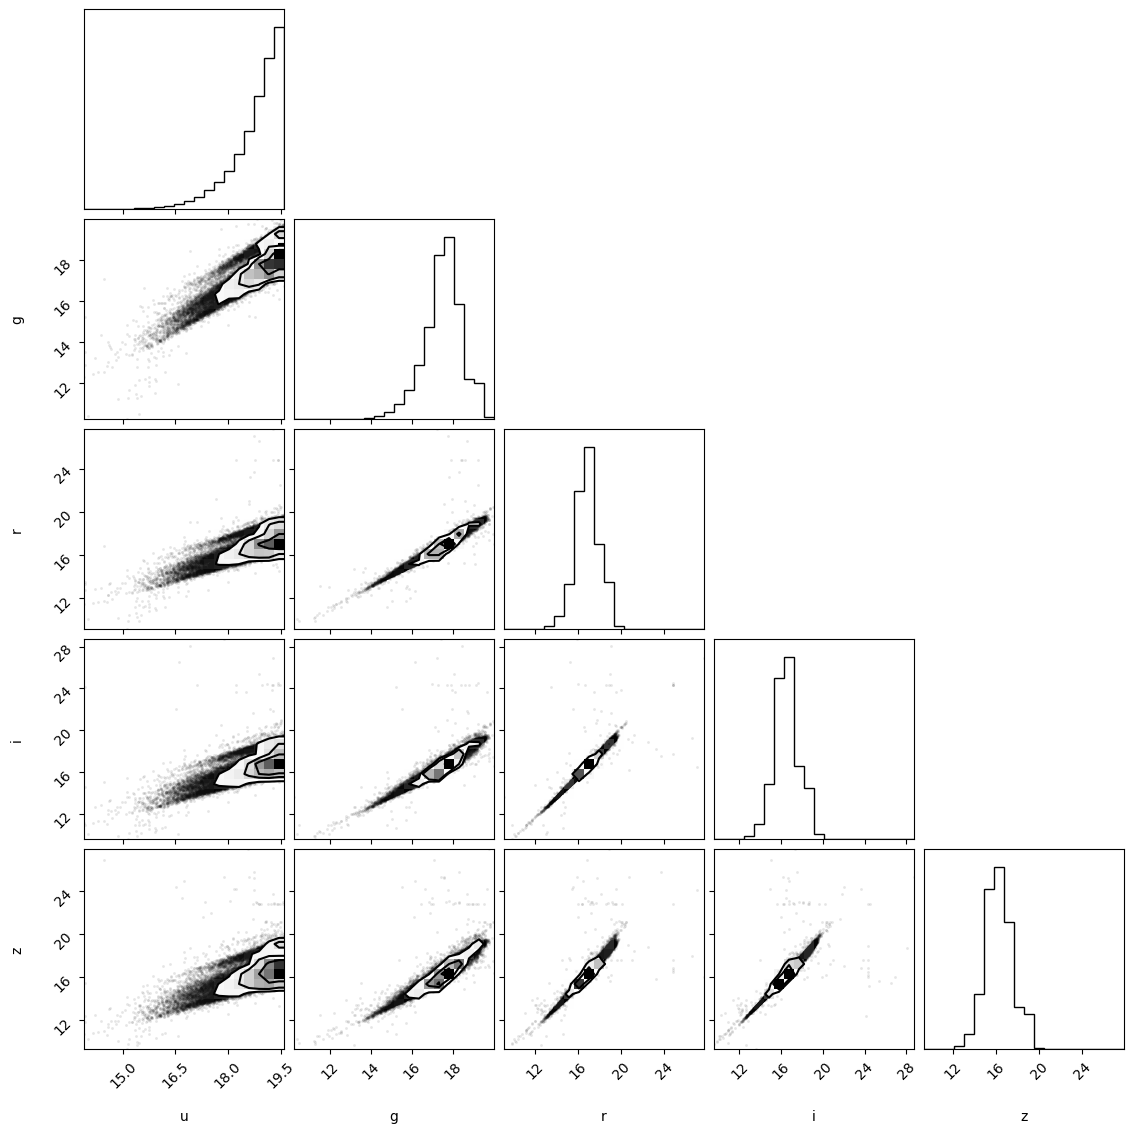

In [14]:
import corner

# Create a DataFrame with the color combinations
color_combinations_df = pd.DataFrame({
    'u': u,
    'g': g,
    'r': r,
    'i': i,
    'z': z,
    'class': class_
})

# Use corner to create a corner plot
figure = corner.corner(color_combinations_df[['u', 'g', 'r', 'i', 'z']], 
                       labels=['u', 'g', 'r', 'i', 'z'], 
                       color='black', 
                       plot_contours=True, 
                       plot_density=True)

plt.show()



In [17]:
u_g = data['u'] - data['g']
g_r =  data['g'] - data['r']
r_i =  data['r'] - data['i']
i_z =  data['i'] - data['z']

print(data['class'])
#print(u_men_g, g_men_r, r_men_i, i_men_z)

0        1
1        0
2        0
3        0
4        1
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: class, Length: 50000, dtype: int64


In [18]:
X = np.concatenate([u_g, g_r, r_i, i_z])
print(X)
y = data['class']

print(X.shape, y.shape)

[0.43537 1.76946 1.73268 ... 0.20103 0.186   0.09355]
(200000,) (50000,)


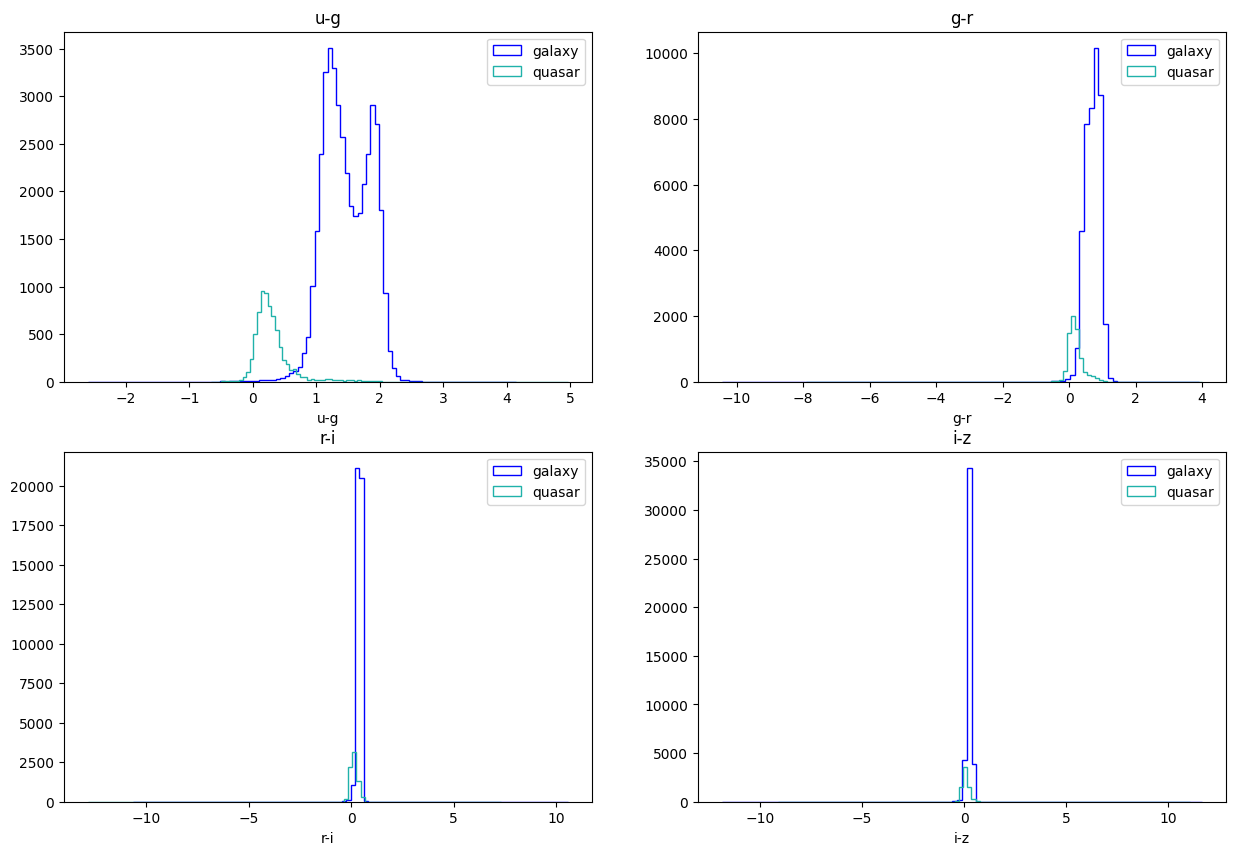

In [19]:
#aybe the one before doesn't make any sense

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

color_diffs = {
    'u-g': u_g,
    'g-r': g_r,
    'r-i': r_i,
    'i-z': i_z
}

for ax, (label, color_diff) in zip(axes.flatten(), color_diffs.items()):

    ax.hist(color_diff[y == 0], bins=100, histtype='step', color='blue', label='galaxy')
    ax.hist(color_diff[y == 1], bins=100, histtype='step', color='lightseagreen', label='quasar')
    ax.set_title(f'{label}')
    ax.set_xlabel(f'{label}')
    ax.legend()


# Some classifiers

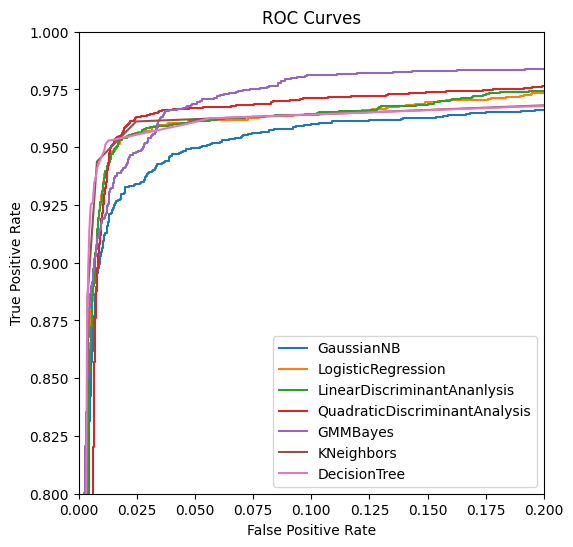

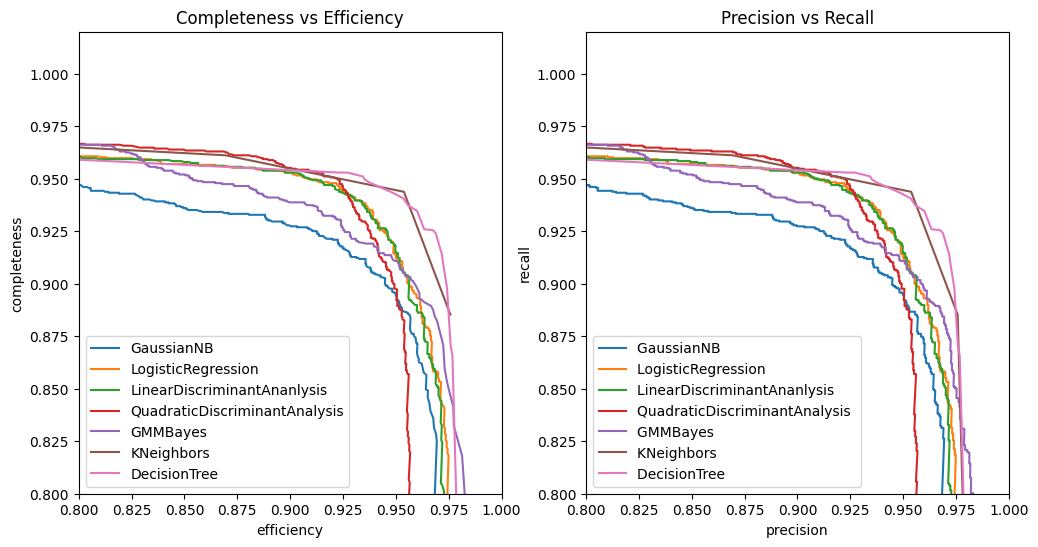

In [22]:
X = np.vstack([u_g, g_r, r_i, i_z]).T  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Classifiers:
classifiers = {
    'GaussianNB': GaussianNB(),
    'LogisticRegression': LogisticRegression(),
    'LinearDiscriminantAnanlysis': LDA(),
    'QuadraticDiscriminantAnalysis': QDA(),
    'GMMBayes': GMMBayes(n_components=3),
    'KNeighbors': KNeighborsClassifier(n_neighbors=3),
    'DecisionTree': DecisionTreeClassifier(max_depth=5), 
}

fig1 = plt.figure(figsize=(6, 6))
ax1 = fig1.add_subplot(111)  

fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 6))

thresholds = np.linspace(0, 1, 1001)[:-1]


for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]

    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])

    # Plot ROC curve
    ax1.plot(fpr, tpr, label=f'{name}')
    
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax2.plot(1 - cont, comp,label=f'{name}' )
    
    ax3.plot(precision, recall, label=f'{name} ')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(loc='lower right')
ax1.set_ylim(0.8, 1)
ax1.set_xlim(0, 0.2)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0.8, 1)
ax2.set_ylim(0.8, 1.02)
ax2.legend(loc='lower left')
ax2.set_title('Completeness vs Efficiency')

ax3.set_xlabel('precision')
ax3.set_ylabel('recall')
ax3.set_xlim(0.8, 1.0)
ax3.set_ylim(0.8, 1.02)
ax3.legend(loc='lower left')
ax3.set_title('Precision vs Recall')

plt.show()


Completeness at 90% efficiency: 0.95
Threshold at 90% efficiency: 0.05


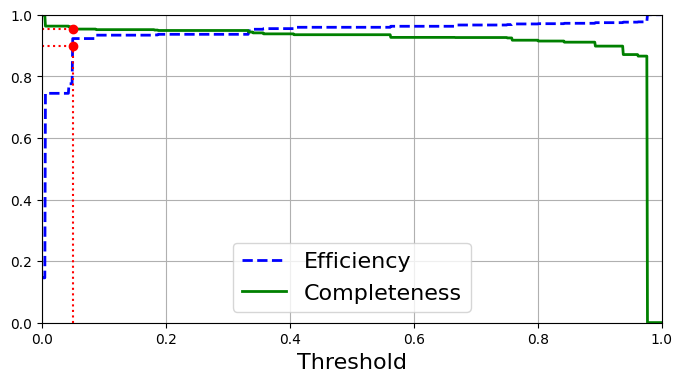

In [88]:
eff = 1-cont

def plot_comp_eff_vs_threshold(eff, comp, thresholds):
    plt.plot(thresholds, eff, "b--", label="Efficiency", linewidth=2)
    plt.plot(thresholds, comp, "g-", label="Completeness", linewidth=2)
    plt.legend(loc="best", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)                
    plt.axis([0, 1, 0, 1])             

comp_90_eff = comp[np.argmax(eff >= 0.90)]
threshold_90_eff = thresholds[np.argmax(eff >= 0.90)]
print(f"Completeness at 90% efficiency: {comp_90_eff:.2f}")
print(f"Threshold at 90% efficiency: {threshold_90_eff:.2f}")

plt.figure(figsize=(8, 4))                                                                  
plot_comp_eff_vs_threshold(eff, comp, thresholds)
plt.plot([threshold_90_eff, threshold_90_eff], [0., 0.9], "r:")                 
plt.plot([0, threshold_90_eff], [0.9, 0.9], "r:")                                
plt.plot([0, threshold_90_eff], [comp_90_eff, comp_90_eff], "r:")
plt.plot([threshold_90_eff], [0.9], "ro")                                             
plt.plot([threshold_90_eff], [comp_90_eff], "ro")                                                                          
plt.show()

## Correlation

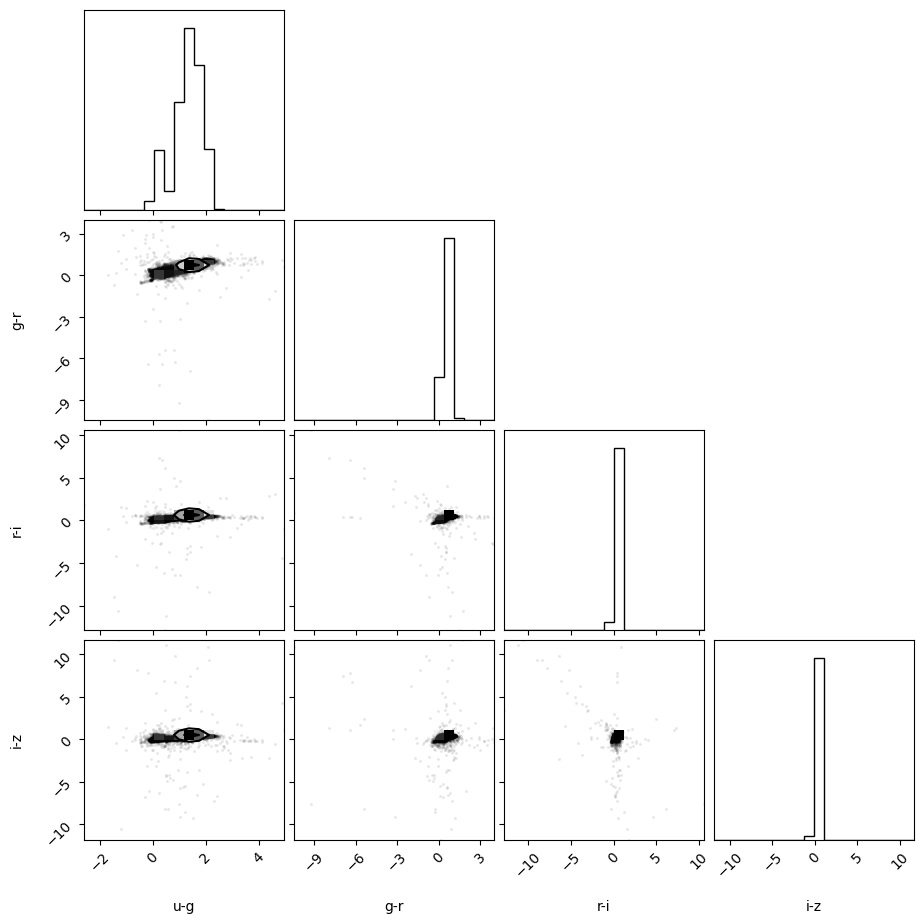

In [107]:
import seaborn as sns
import corner


# Create a DataFrame with the color combinations
color_combinations_df = pd.DataFrame({
    'u-g': u_g,
    'g-r': g_r,
    'r-i': r_i,
    'i-z': i_z,
    'class': data['class']
})

# Use corner to create a corner plot
figure = corner.corner(color_combinations_df[['u-g', 'g-r', 'r-i', 'i-z']], 
                       labels=['u-g', 'g-r', 'r-i', 'i-z'], 
                       color='black', 
                       plot_contours=True, 
                       plot_density=True)

plt.show()

correlation Matrix:
          u-g       g-r       r-i       i-z
u-g  1.000000  0.803315  0.469237  0.360335
g-r  0.803315  1.000000  0.347712  0.318454
r-i  0.469237  0.347712  1.000000 -0.158128
i-z  0.360335  0.318454 -0.158128  1.000000


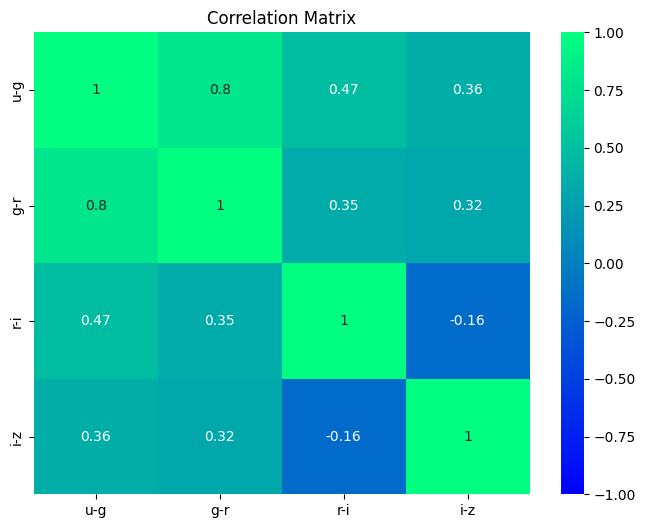

In [89]:
from sklearn.metrics import roc_auc_score
import seaborn as sns

# TO KNOW WHETHER THE COLORS SATISFY THE "NAIVE" ASSUMPION OF INDIPENDENCE"

# Let's calculate the correlation matrix 

color_data = pd.DataFrame({
    'u-g': u_g,
    'g-r': g_r,
    'r-i': r_i,
    'i-z': i_z
})

correlation_matrix = color_data.corr()
print("correlation Matrix:")
print(correlation_matrix)

# Let's plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='winter', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()



Correlation Matrix for Single Colors:
          u         g         r         i         z
u  1.000000  0.808411  0.675389  0.622272  0.582382
g  0.808411  1.000000  0.968982  0.946147  0.928222
r  0.675389  0.968982  1.000000  0.985006  0.975565
i  0.622272  0.946147  0.985006  1.000000  0.979612
z  0.582382  0.928222  0.975565  0.979612  1.000000


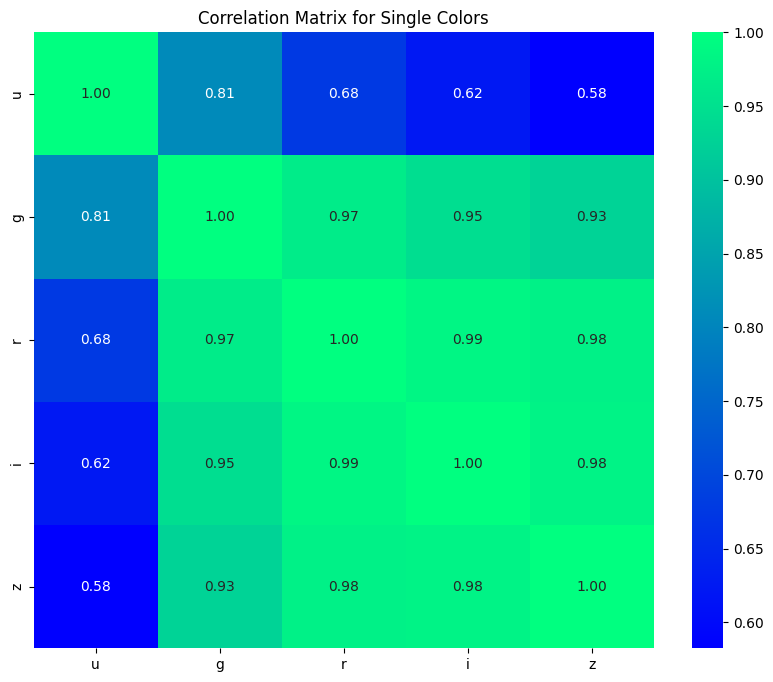

In [90]:
# Correlation matrix for the single colors ----> Does it make any physical sense? Is it the flux difference that matters?
single_color_data = data[['u', 'g', 'r', 'i', 'z']]
correlation_matrix_single_colors = single_color_data.corr()

print("Correlation Matrix for Single Colors:")
print(correlation_matrix_single_colors)

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_single_colors, annot=True, cmap='winter', fmt='.2f')
plt.title('Correlation Matrix for Single Colors')
plt.show()

## Subsets

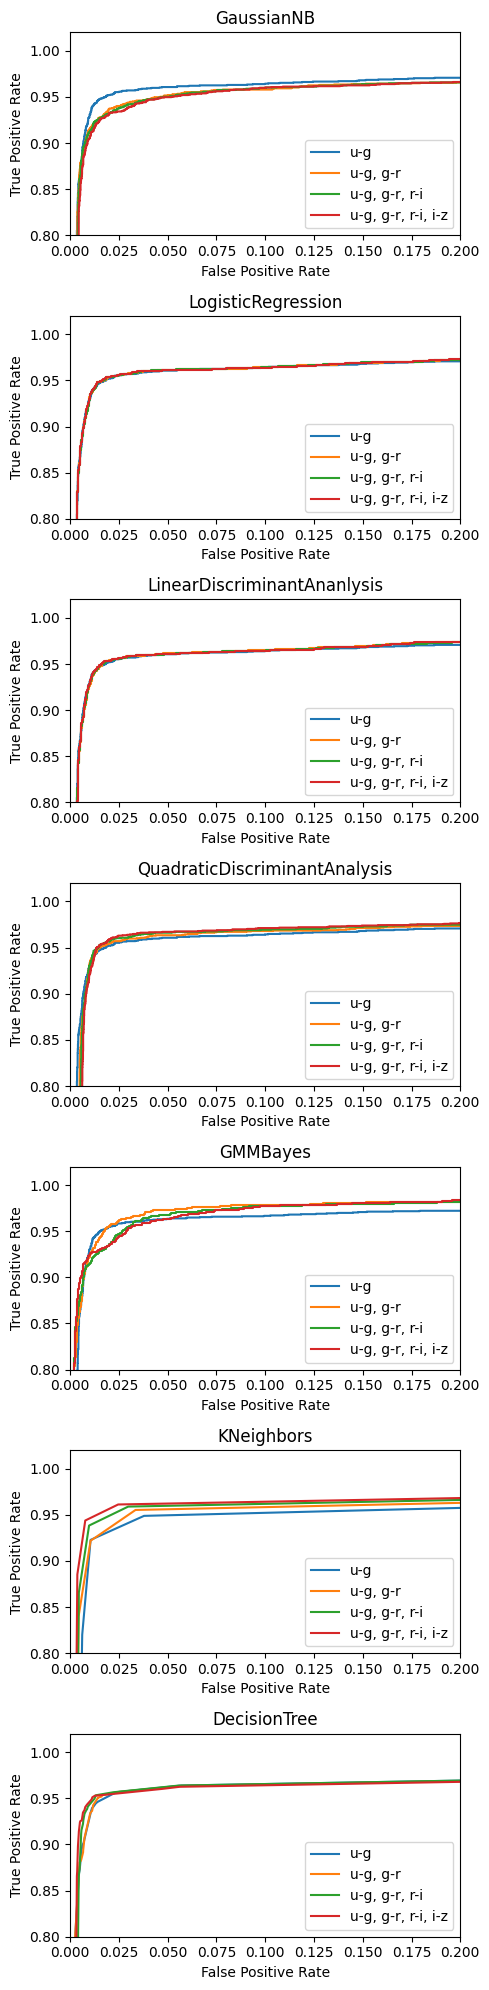

In [34]:
# subsets of features to use
feature_subsets = {
    'u-g': u_g.values.reshape(-1, 1),
    'u-g, g-r': np.vstack([u_g, g_r]).T,
    'u-g, g-r, r-i': np.vstack([u_g, g_r, r_i]).T,
    'u-g, g-r, r-i, i-z': X
}

fig, axes = plt.subplots(len(classifiers), 1, figsize=(5, 20))


for row, (clf_name, clf) in enumerate(classifiers.items()):
    ax = axes[row]
    for subset_name, X_subset in feature_subsets.items():
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, random_state=42)
        
        clf.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        
        ax.plot(fpr, tpr, label=f'{subset_name}')
    
    ax.set_xlim(0, 0.2)
    ax.set_ylim(0.8, 1.02)
    ax.set_title(f'{clf_name}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

/tmp/ipykernel_237809/1166674342.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subsets.keys(), rotation=45)
/tmp/ipykernel_237809/1166674342.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subsets.keys(), rotation=45)
/tmp/ipykernel_237809/1166674342.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subsets.keys(), rotation=45)
/tmp/ipykernel_237809/1166674342.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subsets.keys(), rotation=45)
/tmp/ipykernel_237809/1166674342.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. aft

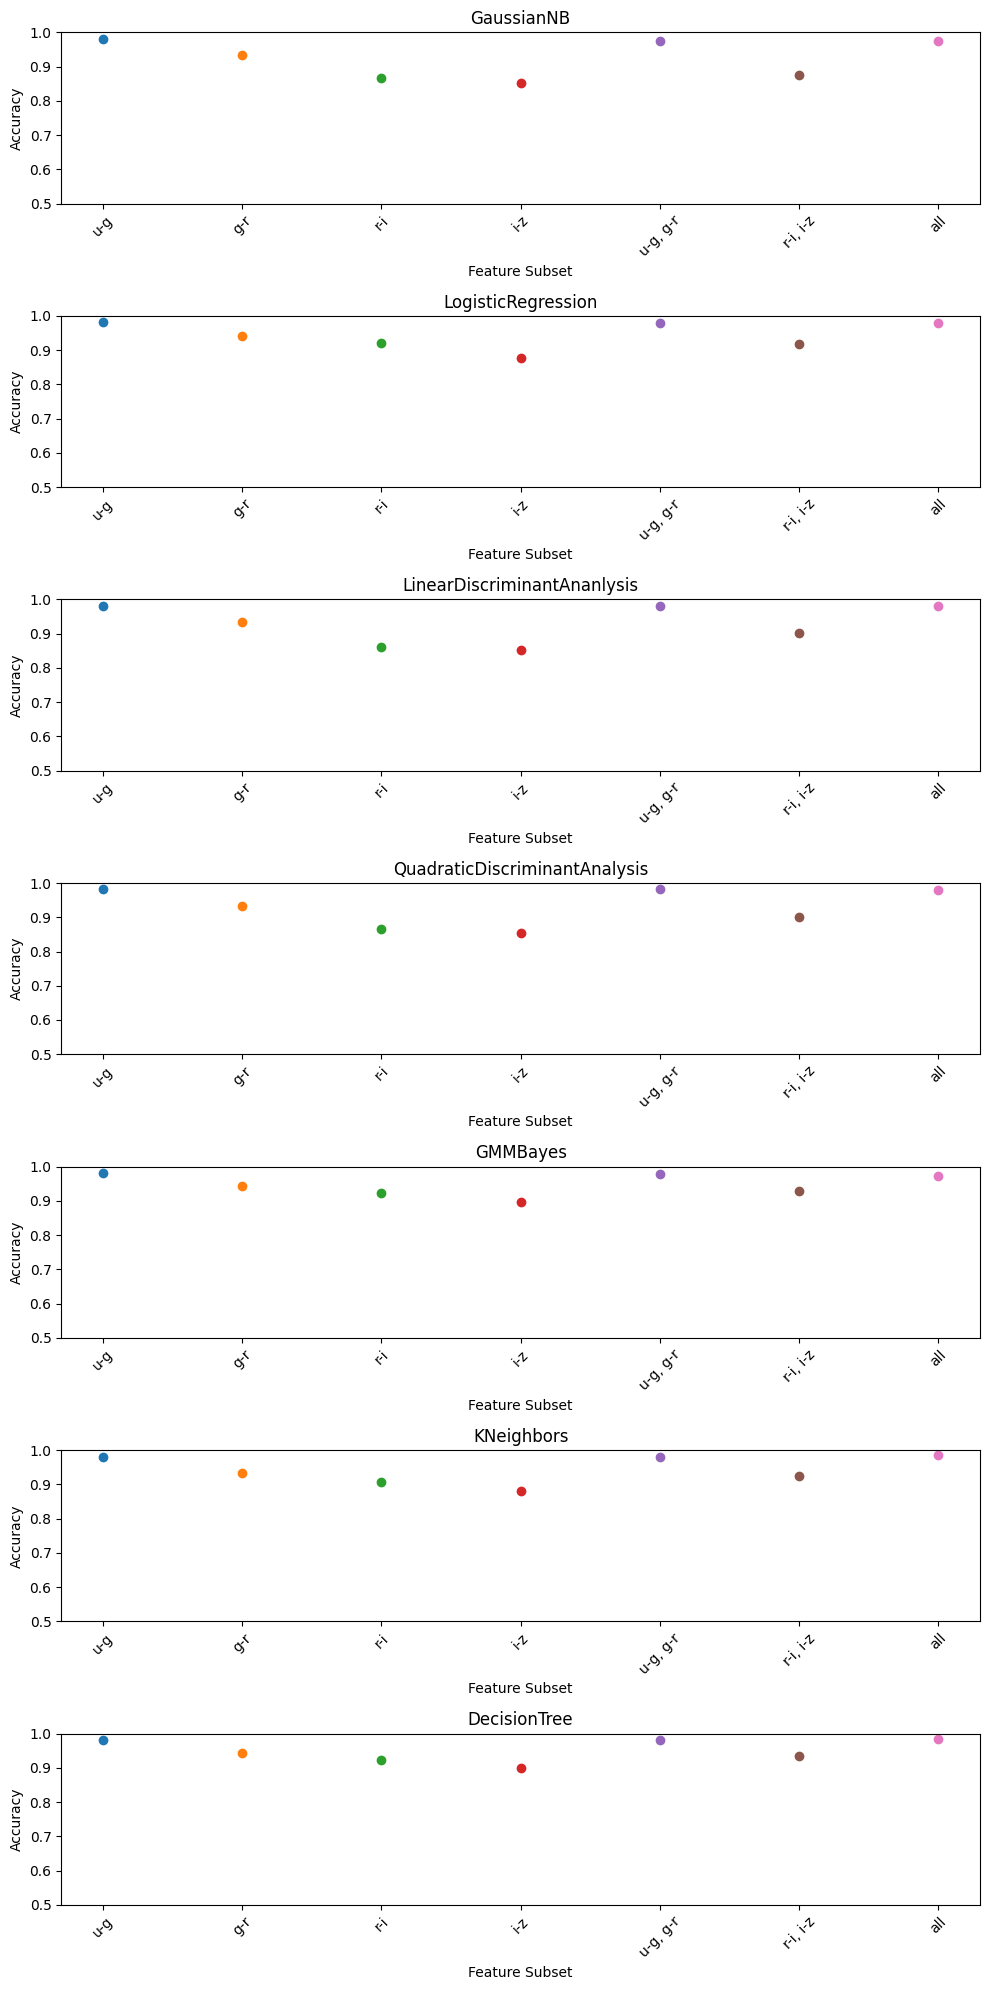

The most indicative subsets are:
GaussianNB: u-g
LogisticRegression: u-g
LinearDiscriminantAnanlysis: u-g
QuadraticDiscriminantAnalysis: u-g, g-r
GMMBayes: u-g
KNeighbors: all
DecisionTree: all


In [41]:
subsets = {
    'u-g': u_g.values.reshape(-1, 1),
    'g-r': g_r.values.reshape(-1, 1),
    'r-i': r_i.values.reshape(-1, 1),
    'i-z': i_z.values.reshape(-1, 1),
    'u-g, g-r': np.vstack([u_g, g_r]).T,
    'r-i, i-z': np.vstack([r_i, i_z]).T,
    'all': X
}
results = {}

fig, axes = plt.subplots(len(classifiers), 1, figsize=(10, 20))

for row, (clf_name, clf) in enumerate(classifiers.items()):
    ax = axes[row]
    for subset_name, X_subset in subsets.items():
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, random_state=42)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        if clf_name not in results:
            results[clf_name] = {}
        results[clf_name][subset_name] = accuracy
        
        ax.plot(subset_name, accuracy, marker='o', linestyle='-', label=f'{subset_name}')
    
    ax.set_title(f'{clf_name}')
    ax.set_xlabel('Feature Subset')
    ax.set_ylabel('Accuracy')
    #ax.legend(loc='lower right')
    ax.set_ylim(0.5, 1.0)
    ax.set_xticklabels(subsets.keys(), rotation=45)

plt.tight_layout()
plt.show()

most_indicative_subset = {}
for clf_name, clf_results in results.items():
    most_indicative_subset[clf_name] = max(clf_results, key=clf_results.get)

print("The most indicative subsets are:")
for clf_name, subset in most_indicative_subset.items():
    print(f"{clf_name}: {subset}")


## Let's see it with PCA

new shape: (50000, 4)
(4, 4)
Explained fractional variance of data encapsulated in the eigenvalues: [0.75887541 0.13734348 0.05896458 0.04481652] 
sum:  0.9999999999999999


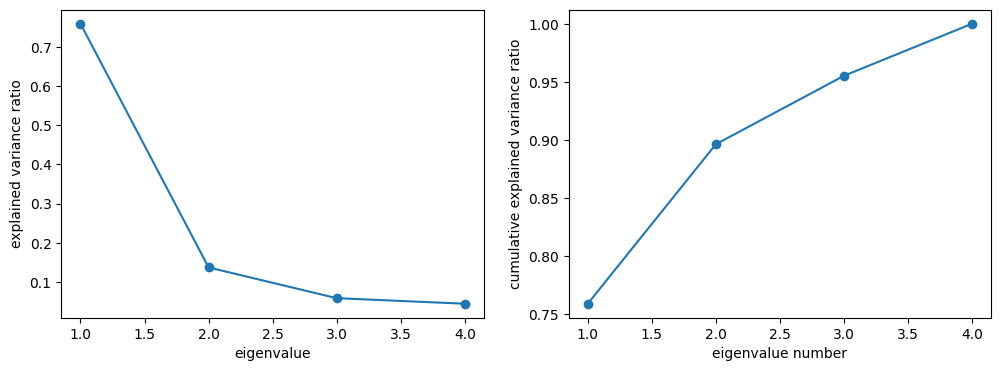

In [25]:
from sklearn.decomposition import PCA
pca= PCA() 
pca.fit(X) 

eigenvalues = pca.transform(X)
mean = pca.mean_
eigenvectors = pca.components_
evals = pca.explained_variance_ratio_ 

# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

print("new shape:", eigenvalues.shape)
print(eigenvectors.shape)

print('Explained fractional variance of data encapsulated in the eigenvalues: ' + str(evals), "\nsum: ", np.sum(evals))

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)


n_components= np.ones(len(pca.explained_variance_ratio_ )) + range(len(pca.explained_variance_ratio_ ))

ax.plot(n_components, evals)
ax.scatter(n_components, evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

ax = fig.add_subplot(122)

ax.plot(n_components, evals.cumsum())
ax.scatter(n_components, evals.cumsum())

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.show()

Number of PCA components: 1, Accuracy: 0.979
Number of PCA components: 2, Accuracy: 0.972
Number of PCA components: 3, Accuracy: 0.972
Number of PCA components: 4, Accuracy: 0.973


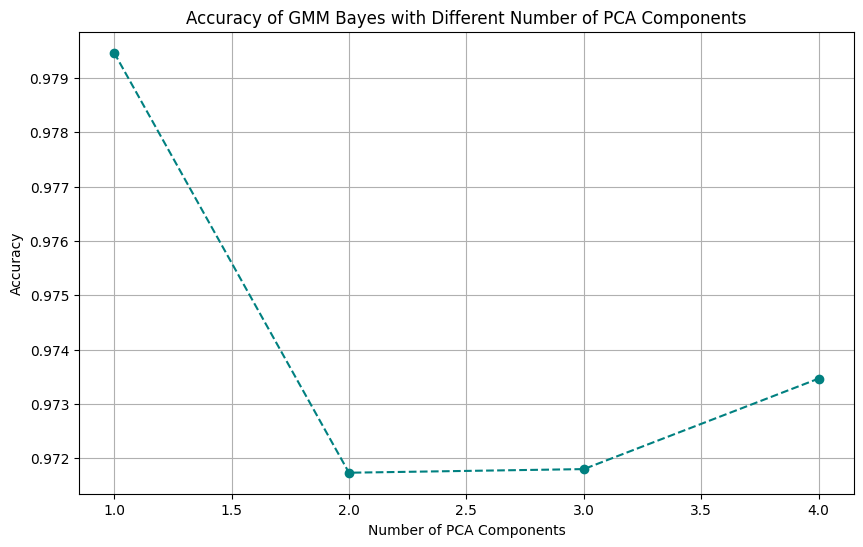

In [26]:
# Evaluate classification with GMM Bayes, changing the number of features
n_components_list = [1, 2, 3, 4]
results = {}

for n_components in n_components_list:
    X_pca_subset = eigenvalues[:, :n_components]
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_subset, y, test_size=0.3, random_state=42)
    
    gmm_bayes = GMMBayes(n_components=3)
    gmm_bayes.fit(X_train_pca, y_train_pca)
    
    y_pred_pca = gmm_bayes.predict(X_test_pca)
    accuracy = accuracy_score(y_test_pca, y_pred_pca)
    results[n_components] = accuracy
    print(f"Number of PCA components: {n_components}, Accuracy: {accuracy:.3f}")

# Plot the accuracy for different number of PCA components
plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o', linestyle='--', color='teal')
plt.title('Accuracy of GMM Bayes with Different Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()